In [2]:
%%capture
pip install openeo geopandas shapely


In [3]:
import openeo
from shapely.geometry import box
import datetime

# 1. Connect ke backend Copernicus Data Space via OpenEO
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=KFOX-BNQO 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.


In [7]:
import openeo
from shapely.geometry import box

# 1. Koneksi ke OpenEO Copernicus
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

# 2. Definisikan area Bangkalan (koordinat EPSG:4326)
bbox = box(112.7, -7.2, 113.1, -6.9)
spatial_extent = {
    "west": bbox.bounds[0],
    "south": bbox.bounds[1],
    "east": bbox.bounds[2],
    "north": bbox.bounds[3],
    "crs": "EPSG:4326"
}

# 3. Waktu pencitraan
temporal_extent = ["2024-05-01", "2024-05-10"]

# 4. Load data Sentinel-2 L2A dengan band: B04 (red), B08 (NIR), dan SCL
datacube = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=spatial_extent,
    temporal_extent=temporal_extent,
    bands=["B04", "B08", "SCL"]
)

# 5. Ambil band klasifikasi awan (SCL)
scl = datacube.band("SCL")

# 6. Buat mask berdasarkan nilai SCL untuk area bebas awan
# SCL values: 4 = vegetation, 5 = bare soil, 6 = water, 7 = shadow
cloud_free_mask = (scl == 4) | (scl == 5) | (scl == 6) | (scl == 7)

# 7. Terapkan masking ke datacube
masked = datacube.mask(cloud_free_mask)

# 8. Hitung NDVI dari band yang sudah di-mask
ndvi_cube = masked.ndvi(nir="B08", red="B04")

# 9. Ambil nilai median sepanjang waktu (jika ada beberapa citra)
reduced_ndvi = ndvi_cube.reduce_dimension(dimension="t", reducer="median")

# 10. Jalankan proses dan simpan hasil ke GeoTIFF
job = reduced_ndvi.execute_batch(
    outputfile="ndvi_bangkalan.tif",
    format="GTiff"
)

print("✅ NDVI selesai dihitung dan disimpan sebagai ndvi_bangkalan.tif")


Authenticated using refresh token.
0:00:00 Job 'j-2505070434464783bf8a08eb7ad8c2c8': send 'start'
0:00:12 Job 'j-2505070434464783bf8a08eb7ad8c2c8': created (progress 0%)
0:00:18 Job 'j-2505070434464783bf8a08eb7ad8c2c8': created (progress 0%)
0:00:24 Job 'j-2505070434464783bf8a08eb7ad8c2c8': running (progress N/A)
0:00:32 Job 'j-2505070434464783bf8a08eb7ad8c2c8': running (progress N/A)
0:00:42 Job 'j-2505070434464783bf8a08eb7ad8c2c8': running (progress N/A)
0:00:54 Job 'j-2505070434464783bf8a08eb7ad8c2c8': running (progress N/A)
0:01:09 Job 'j-2505070434464783bf8a08eb7ad8c2c8': running (progress N/A)
0:01:29 Job 'j-2505070434464783bf8a08eb7ad8c2c8': running (progress N/A)
0:01:53 Job 'j-2505070434464783bf8a08eb7ad8c2c8': running (progress N/A)
0:02:23 Job 'j-2505070434464783bf8a08eb7ad8c2c8': finished (progress 100%)
✅ NDVI selesai dihitung dan disimpan sebagai ndvi_bangkalan.tif


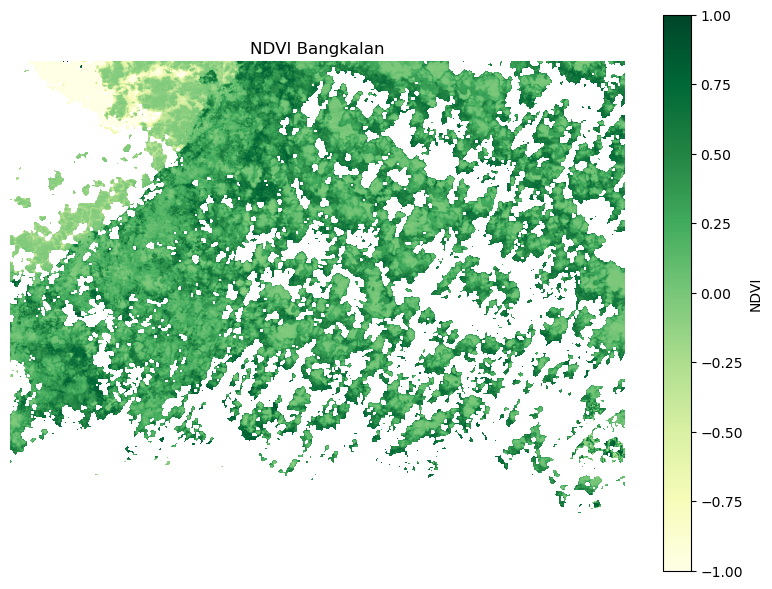

In [8]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np

# 1. Buka file NDVI
with rasterio.open("ndvi_bangkalan.tif") as src:
    ndvi = src.read(1)  # Ambil band pertama
    ndvi = np.where(ndvi == src.nodata, np.nan, ndvi)  # Mask nilai nodata

# 2. Plot NDVI dengan colormap hijau
plt.figure(figsize=(8, 6))
plt.imshow(ndvi, cmap="YlGn", norm=Normalize(vmin=-1, vmax=1))
plt.colorbar(label="NDVI")
plt.title("NDVI Bangkalan")
plt.axis("off")
plt.tight_layout()
plt.show()


In [9]:
import rasterio
import numpy as np
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape

# 1. Baca NDVI raster
with rasterio.open("ndvi_bangkalan.tif") as src:
    ndvi = src.read(1)
    ndvi = np.where(ndvi == src.nodata, np.nan, ndvi)
    mask = ~np.isnan(ndvi)
    transform = src.transform
    crs = src.crs

# 2. (Opsional) Klasifikasikan NDVI ke kelas
# Contoh 3 kelas: 0–0.33 = rendah, 0.33–0.66 = sedang, >0.66 = tinggi
ndvi_class = np.zeros_like(ndvi, dtype=np.uint8)
ndvi_class[(ndvi > 0.0) & (ndvi <= 0.33)] = 1
ndvi_class[(ndvi > 0.33) & (ndvi <= 0.66)] = 2
ndvi_class[(ndvi > 0.66)] = 3

# 3. Konversi ke bentuk vektor (shapely polygons)
results = (
    {"geometry": shape(geom), "properties": {"class": value}}
    for geom, value in shapes(ndvi_class, mask=mask, transform=transform)
    if value > 0  # Hanya area dengan kelas
)

# 4. Buat GeoDataFrame dan simpan sebagai Shapefile
gdf = gpd.GeoDataFrame.from_features(list(results), crs=crs)
gdf.to_file("ndvi_bangkalan.shp")

print("✅ NDVI berhasil dikonversi ke shapefile: ndvi_bangkalan.shp")


✅ NDVI berhasil dikonversi ke shapefile: ndvi_bangkalan.shp


<Figure size 800x600 with 0 Axes>

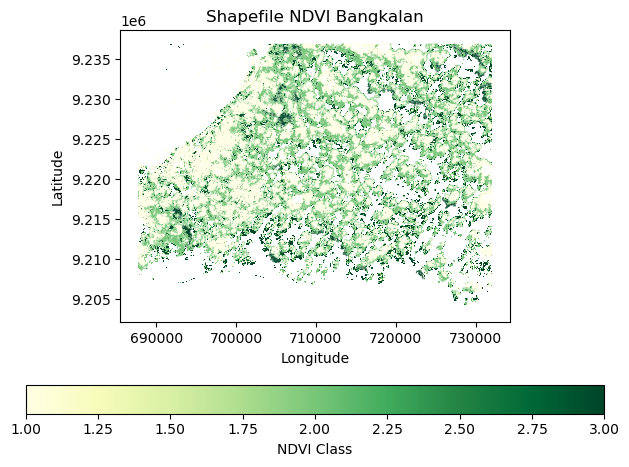

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. Baca shapefile
gdf = gpd.read_file("ndvi_bangkalan.shp")

# 2. Plot shapefile
plt.figure(figsize=(8, 6))
gdf.plot(column='class', cmap='YlGn', legend=True,
         legend_kwds={'label': "NDVI Class",
                      'orientation': "horizontal"})
plt.title("Shapefile NDVI Bangkalan")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()
